In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_df = pd.read_csv("./data/train.csv", header=0)
raw_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
raw_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The Passenger ID and the Ticket ID are not needed:

In [4]:
raw_df.drop("PassengerId", axis=1, inplace=True)
raw_df.drop("Ticket", axis=1, inplace=True)

# Preprocessing:

Notice that we won't be using libraries (e.g. sklearn.preprocessing) for label encoding (except for Gender), but instead, we'll encode according to "Survival" chance (a feature or value with a higher survival chance will get a higher encoding number)

In [5]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

scaler = StandardScaler()

In [6]:
pre_df = raw_df.copy()

##### Check NaN values:

In [7]:
raw_df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### Gender: Survival chance and Encoding

Check Gender importance in survival:

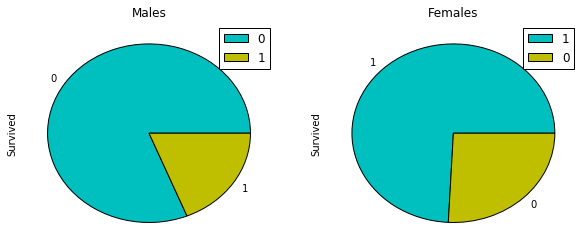

In [8]:
fig = plt.figure(figsize=(10, 4))

fig.add_subplot(121)
raw_df["Survived"][raw_df["Sex"] == "male"].value_counts().plot(kind="pie", title="Males", legend=True, colors=['c', 'y'])

fig.add_subplot(122)
raw_df["Survived"][raw_df["Sex"] == "female"].value_counts().plot(kind="pie", title="Females", legend=True, colors=['c', 'y']);

In [9]:
from sklearn.preprocessing import LabelBinarizer

pre_df["Sex"] = LabelBinarizer().fit_transform(raw_df["Sex"])

### Name / Title : Survival chance according to Title
/!\ Encoding is done later

In [10]:
pre_df["Name"] = raw_df["Name"].map(lambda x: x.split(',')[1].split('.')[0].strip())

In [11]:
titles = pre_df["Name"].unique()
print("# of titles:", len(titles))
print(titles)

# of titles: 17
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']


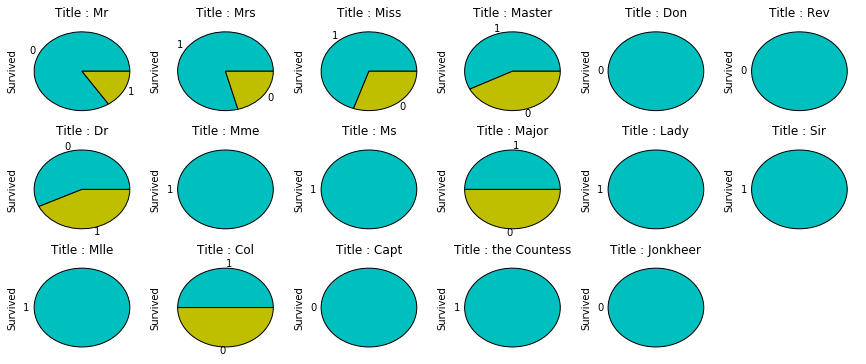

In [12]:
fig = plt.figure(figsize=(15,6))

for title_i in range(len(titles)):
    fig.add_subplot(3, 6, title_i + 1)
    plt.title('Title : {}'.format(titles[title_i]))
    pre_df["Survived"][pre_df["Name"] == titles[title_i]].value_counts().plot(kind="pie", colors=['c', 'y'])

### Age: NaN fill and Normalizing
We'll fill NaNs with the median with regards to Title ('Mr', 'Master', ...)

In [13]:
pre_df["Age"].fillna(-1, inplace=True)

medians = {}
for title_i in range(len(titles)):
    median = pre_df["Age"][(pre_df["Age"] != -1) & (pre_df["Name"] == titles[title_i])].median()
    medians[titles[title_i]] = median
    
for idx, row in pre_df.iterrows():
    if row["Age"] == -1:
        pre_df.loc[idx, "Age"] = medians[row["Name"]]

In [14]:
pre_df["Age"] = scaler.fit_transform(pre_df[["Age"]])

### Name / Title : (Next) Encoding and Normalizing

In [15]:
replacement = {
    'Don': 0,
    'Rev': 0,
    'Jonkheer': 0,
    'Capt': 0,
    'Mr': 1,
    'Dr': 2,
    'Col': 3,
    'Major': 3,
    'Master': 4,
    'Miss': 5,
    'Mrs': 6,
    'Mme': 7,
    'Ms': 7,
    'Mlle': 7,
    'Sir': 7,
    'Lady': 7,
    'the Countess': 7
}

pre_df["Name"] = pre_df["Name"].apply(lambda x: replacement.get(x))

In [16]:
pre_df["Name"] = scaler.fit_transform(pre_df[["Name"]])

### Cabin: NaN fill, Survival chance and Encoding
Notice that we'll fill NaNs with median with regards to passenger class "Pclass"

In [17]:
pre_df["Cabin"].fillna('U', inplace=True)

pre_df["Cabin"] = pre_df["Cabin"].apply(lambda x: x[0])

cabins = pre_df["Cabin"].unique()
print(cabins)

['U' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


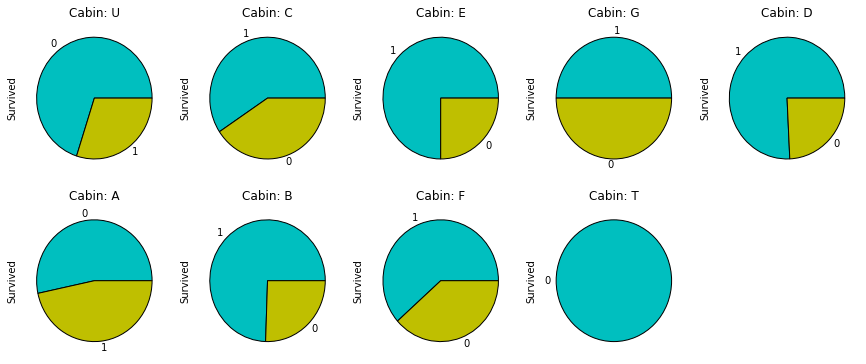

In [18]:
fig = plt.figure(figsize=(15, 6))

for cab_i in range(len(cabins)):
    fig.add_subplot(2, 5, cab_i + 1)
    plt.title("Cabin: {}".format(cabins[cab_i]))
    pre_df["Survived"][pre_df["Cabin"] == cabins[cab_i]].value_counts().plot(kind="pie", colors=['c', 'y'])

In [19]:
#pre_df["Cabin"] = LabelEncoder().fit_transform(pre_df["Cabin"])

replacement = {
    'T': 0,
    'U': 1,
    'A': 2,
    'G': 3,
    'C': 4,
    'F': 5,
    'B': 6,
    'E': 7,
    'D': 8   
}

pre_df["Cabin"] = pre_df["Cabin"].apply(lambda x: replacement.get(x))

In [20]:
"""
classes = pre_df["Pclass"].unique()

medians = {}
for clss_i in range(len(classes)):
    median = pre_df["Cabin"][(pre_df["Cabin"] != 1) & (pre_df["Pclass"] == classes[clss_i])].median()
    medians[classes[clss_i]] = median
    
print(medians)

for idx, row in pre_df.iterrows():
    if row["Age"] == -1:
        pre_df.loc[idx, "Age"] = medians[row["Name"]]
"""

'\nclasses = pre_df["Pclass"].unique()\n\nmedians = {}\nfor clss_i in range(len(classes)):\n    median = pre_df["Cabin"][(pre_df["Cabin"] != 1) & (pre_df["Pclass"] == classes[clss_i])].median()\n    medians[classes[clss_i]] = median\n    \nprint(medians)\n\nfor idx, row in pre_df.iterrows():\n    if row["Age"] == -1:\n        pre_df.loc[idx, "Age"] = medians[row["Name"]]\n'

In [21]:
pre_df[["Cabin"]] = scaler.fit_transform(pre_df[["Cabin"]])

### Embarkment port: Chance of survival, NaN fill, and One Hot Encoding

In [22]:
pre_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

We see the majority embarked from 'S' (Southampton), so :

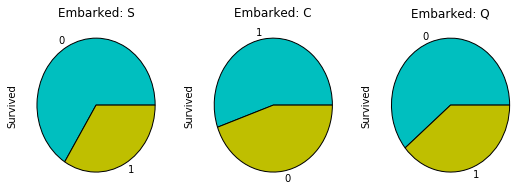

In [23]:
pre_df["Embarked"].fillna('S', inplace=True)
emb_ports = pre_df["Embarked"].unique()

fig = plt.figure(figsize=(9, 3))
for emb_i in range(len(emb_ports)):
    fig.add_subplot(1, 3, emb_i + 1)
    plt.title("Embarked: {}".format(emb_ports[emb_i]))
    pre_df["Survived"][pre_df["Embarked"] == emb_ports[emb_i]].value_counts().plot(kind="pie", colors=['c', 'y'])

In [24]:
replacement = {
    'S': 0,
    'Q': 1,
    'C': 2
}

pre_df["Embarked"] = pre_df["Embarked"].apply(lambda x: replacement.get(x))

In [25]:
pre_df["Embarked"] = scaler.fit_transform(pre_df[["Embarked"]])

### Normalizing the rest:

In [26]:
pre_df["Fare"] = scaler.fit_transform(pre_df[["Fare"]])
pre_df["SibSp"] = scaler.fit_transform(pre_df[["SibSp"]])
pre_df["Parch"] = scaler.fit_transform(pre_df[["Parch"]])
pre_df["Pclass"] = scaler.fit_transform(pre_df[["Pclass"]])
pre_df["Sex"] = scaler.fit_transform(pre_df[["Sex"]])

## Saving to CSV:

In [28]:
pre_df.to_csv("./data/preproc_train.csv", header=True, index=False)

# Training Day:

In [30]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    pre_df.drop("Survived", axis=1),
    pre_df["Survived"],
    test_size=0.2
)

### Random Forest:

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=123)

forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [32]:
forest_train_score = forest.score(x_train, y_train)
print(forest_train_score)

0.98595505618


In [33]:
forest_test_score = forest.score(x_test, y_test)
print(forest_test_score)

0.826815642458


### TensorFlow NN:

In [34]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)

In [35]:
def get_batch(xs, ys, batch_size=50):
    
    assert(xs.shape[0] == ys.shape[0])

    idxs = np.random.permutation(range(xs.shape[0]))
    
    n_batches = len(xs) // batch_size
    
    for batch_i in range(n_batches):
        
        """
        batch_x = xs[batch_i * batch_size : (batch_i + 1) * batch_size]
        batch_y = ys[batch_i * batch_size : (batch_i + 1) * batch_size]
        """
        
        idxs_i = idxs[batch_i * batch_size : (batch_i + 1) * batch_size]
        
        batch_x = xs.iloc[idxs_i]
        batch_y = ys.iloc[idxs_i]
        yield batch_x, batch_y

In [36]:
def build_nn(n_inputs, n_outputs, activation=tf.nn.relu, n_hidden_layers=1,
             n_hidden_units=10, optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
             scope=None):

    tf.reset_default_graph()

    with tf.variable_scope(scope or "neural_net", ):
        X = tf.placeholder(dtype=tf.float32, shape=[None, n_inputs])
        Y = tf.placeholder(dtype=tf.float32, shape=[None, n_outputs])

        Y_feedforward = X
        for _ in range(n_hidden_layers):
            Y_feedforward = tf.layers.dense(
                inputs=Y_feedforward,
                units=n_hidden_units,
                activation=activation,
                kernel_initializer=tf.contrib.layers.xavier_initializer()
            )

        # Output layer:
        logits = tf.layers.dense(inputs=Y_feedforward, units=1, activation=None)
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits)
        cost = tf.reduce_mean(cross_entropy)
        optimizer = optimizer.minimize(cost)
        Y_pred = tf.round(tf.sigmoid(logits))

        return X, Y, Y_pred, cost, optimizer

In [37]:
def predict(xs, Y_pred, sess):
    with sess.as_default():
        return Y_pred.eval(
            session=sess,
            feed_dict={
                X: xs
            }
        )

def accuracy(y_pred, y_target):
    return np.mean(np.equal(y_pred, y_target).astype(np.float32))

In [38]:
def train(xs, ys, Y_pred, optimizer, loss, sess, epochs=1000, batch_size=50):
    
    with sess.as_default():
        
        costs = []
        accuracies = []
        n_batches = len(xs) // batch_size
        
        ys = ys.values.reshape(-1, 1)
        
        sess.run(tf.global_variables_initializer())
        
        for iter_i in range(1, epochs + 1):
            
            for batch_x, batch_y in get_batch(xs, pd.DataFrame(ys), batch_size):
                
                train_cost = sess.run(
                    fetches=[loss, optimizer],
                    feed_dict={
                        X: batch_x,
                        Y: batch_y
                    }
                )[0]
               
            
            if iter_i % 10 == 0:
                costs.append(train_cost)
                
                acc = accuracy(
                    y_pred=predict(xs=xs, Y_pred=Y_pred, sess=sess),
                    y_target=ys
                )
                accuracies.append(acc)
                
                print("Epoch: {}/{}".format(iter_i, epochs))
                print('\t', "Train Cost: {}".format(train_cost))
                print('\t', "Train Acc: {}".format(acc))
                
        return Y_pred

In [39]:
X, Y, Y_pred, cost, optim = build_nn(
    n_inputs=x_train.shape[1],
    n_outputs=1,
    activation=tf.nn.relu,
    n_hidden_layers=1,
    n_hidden_units=9,
    optimizer=tf.train.AdamOptimizer(0.01)
)

assert(X.get_shape().as_list() == [None, x_train.shape[1]])
assert(Y.get_shape().as_list() == [None, 1])
assert(Y_pred.get_shape().as_list() == [None, 1])

with tf.Session() as sess:
    Y_trained = train(
        sess=sess,
        xs=x_train,
        ys=y_train,
        Y_pred=Y_pred,
        loss=cost,
        optimizer=optim,
        epochs=10000,
        batch_size=50
    )
    
    print(accuracy(
        y_pred=predict(Y_pred=Y_trained, xs=x_train, sess=sess),
        y_target=y_train.values.reshape(-1, 1)
    ))

Epoch: 10/10000
	 Train Cost: 0.3095165193080902
	 Train Acc: 0.8525280952453613
Epoch: 20/10000
	 Train Cost: 0.5360211730003357
	 Train Acc: 0.8553370833396912
Epoch: 30/10000
	 Train Cost: 0.2810772955417633
	 Train Acc: 0.8567415475845337
Epoch: 40/10000
	 Train Cost: 0.2521934509277344
	 Train Acc: 0.8595505356788635
Epoch: 50/10000
	 Train Cost: 0.26337721943855286
	 Train Acc: 0.8567415475845337
Epoch: 60/10000
	 Train Cost: 0.2721528112888336
	 Train Acc: 0.8623595237731934
Epoch: 70/10000
	 Train Cost: 0.3359316289424896
	 Train Acc: 0.8553370833396912
Epoch: 80/10000
	 Train Cost: 0.33043694496154785
	 Train Acc: 0.8553370833396912
Epoch: 90/10000
	 Train Cost: 0.272748738527298
	 Train Acc: 0.8567415475845337
Epoch: 100/10000
	 Train Cost: 0.2117263823747635
	 Train Acc: 0.8567415475845337
Epoch: 110/10000
	 Train Cost: 0.4485659897327423
	 Train Acc: 0.8553370833396912
Epoch: 120/10000
	 Train Cost: 0.31580430269241333
	 Train Acc: 0.8595505356788635
Epoch: 130/10000
	 Trai

Epoch: 1010/10000
	 Train Cost: 0.44238483905792236
	 Train Acc: 0.867977499961853
Epoch: 1020/10000
	 Train Cost: 0.30036357045173645
	 Train Acc: 0.8665730357170105
Epoch: 1030/10000
	 Train Cost: 0.307407945394516
	 Train Acc: 0.8665730357170105
Epoch: 1040/10000
	 Train Cost: 0.3128344714641571
	 Train Acc: 0.8665730357170105
Epoch: 1050/10000
	 Train Cost: 0.33400240540504456
	 Train Acc: 0.867977499961853
Epoch: 1060/10000
	 Train Cost: 0.3247761130332947
	 Train Acc: 0.8637640476226807
Epoch: 1070/10000
	 Train Cost: 0.2775237560272217
	 Train Acc: 0.8707864880561829
Epoch: 1080/10000
	 Train Cost: 0.25879979133605957
	 Train Acc: 0.8637640476226807
Epoch: 1090/10000
	 Train Cost: 0.42807140946388245
	 Train Acc: 0.8665730357170105
Epoch: 1100/10000
	 Train Cost: 0.29564806818962097
	 Train Acc: 0.875
Epoch: 1110/10000
	 Train Cost: 0.37393879890441895
	 Train Acc: 0.8651685118675232
Epoch: 1120/10000
	 Train Cost: 0.282818078994751
	 Train Acc: 0.867977499961853
Epoch: 1130/100

Epoch: 2000/10000
	 Train Cost: 0.2963092029094696
	 Train Acc: 0.867977499961853
Epoch: 2010/10000
	 Train Cost: 0.3143600523471832
	 Train Acc: 0.8665730357170105
Epoch: 2020/10000
	 Train Cost: 0.1593524068593979
	 Train Acc: 0.8651685118675232
Epoch: 2030/10000
	 Train Cost: 0.27028679847717285
	 Train Acc: 0.8721910119056702
Epoch: 2040/10000
	 Train Cost: 0.2787909209728241
	 Train Acc: 0.8693820238113403
Epoch: 2050/10000
	 Train Cost: 0.1534816324710846
	 Train Acc: 0.8665730357170105
Epoch: 2060/10000
	 Train Cost: 0.27989956736564636
	 Train Acc: 0.8665730357170105
Epoch: 2070/10000
	 Train Cost: 0.2470436543226242
	 Train Acc: 0.8693820238113403
Epoch: 2080/10000
	 Train Cost: 0.33102166652679443
	 Train Acc: 0.8665730357170105
Epoch: 2090/10000
	 Train Cost: 0.3060464560985565
	 Train Acc: 0.8693820238113403
Epoch: 2100/10000
	 Train Cost: 0.4908280074596405
	 Train Acc: 0.8693820238113403
Epoch: 2110/10000
	 Train Cost: 0.29938387870788574
	 Train Acc: 0.867977499961853
Ep

Epoch: 2990/10000
	 Train Cost: 0.288883239030838
	 Train Acc: 0.8665730357170105
Epoch: 3000/10000
	 Train Cost: 0.29135870933532715
	 Train Acc: 0.867977499961853
Epoch: 3010/10000
	 Train Cost: 0.34326252341270447
	 Train Acc: 0.8735954761505127
Epoch: 3020/10000
	 Train Cost: 0.3144962191581726
	 Train Acc: 0.8707864880561829
Epoch: 3030/10000
	 Train Cost: 0.2674520015716553
	 Train Acc: 0.8665730357170105
Epoch: 3040/10000
	 Train Cost: 0.3068777322769165
	 Train Acc: 0.8707864880561829
Epoch: 3050/10000
	 Train Cost: 0.2191067337989807
	 Train Acc: 0.867977499961853
Epoch: 3060/10000
	 Train Cost: 0.3167363405227661
	 Train Acc: 0.867977499961853
Epoch: 3070/10000
	 Train Cost: 0.47250816226005554
	 Train Acc: 0.8707864880561829
Epoch: 3080/10000
	 Train Cost: 0.32032206654548645
	 Train Acc: 0.8707864880561829
Epoch: 3090/10000
	 Train Cost: 0.2893175184726715
	 Train Acc: 0.8665730357170105
Epoch: 3100/10000
	 Train Cost: 0.2796379327774048
	 Train Acc: 0.8665730357170105
Epoc

Epoch: 3980/10000
	 Train Cost: 0.2718309462070465
	 Train Acc: 0.8693820238113403
Epoch: 3990/10000
	 Train Cost: 0.35939547419548035
	 Train Acc: 0.8693820238113403
Epoch: 4000/10000
	 Train Cost: 0.3072454631328583
	 Train Acc: 0.867977499961853
Epoch: 4010/10000
	 Train Cost: 0.393955796957016
	 Train Acc: 0.8707864880561829
Epoch: 4020/10000
	 Train Cost: 0.3649783730506897
	 Train Acc: 0.8665730357170105
Epoch: 4030/10000
	 Train Cost: 0.4346880614757538
	 Train Acc: 0.8707864880561829
Epoch: 4040/10000
	 Train Cost: 0.32496529817581177
	 Train Acc: 0.8735954761505127
Epoch: 4050/10000
	 Train Cost: 0.33383384346961975
	 Train Acc: 0.875
Epoch: 4060/10000
	 Train Cost: 0.3311742842197418
	 Train Acc: 0.8651685118675232
Epoch: 4070/10000
	 Train Cost: 0.3484228253364563
	 Train Acc: 0.8665730357170105
Epoch: 4080/10000
	 Train Cost: 0.2713623642921448
	 Train Acc: 0.8651685118675232
Epoch: 4090/10000
	 Train Cost: 0.4178772270679474
	 Train Acc: 0.8665730357170105
Epoch: 4100/1000

Epoch: 4970/10000
	 Train Cost: 0.37600165605545044
	 Train Acc: 0.8665730357170105
Epoch: 4980/10000
	 Train Cost: 0.20254096388816833
	 Train Acc: 0.8707864880561829
Epoch: 4990/10000
	 Train Cost: 0.35755833983421326
	 Train Acc: 0.8693820238113403
Epoch: 5000/10000
	 Train Cost: 0.28964489698410034
	 Train Acc: 0.867977499961853
Epoch: 5010/10000
	 Train Cost: 0.23433874547481537
	 Train Acc: 0.8693820238113403
Epoch: 5020/10000
	 Train Cost: 0.3482700288295746
	 Train Acc: 0.8693820238113403
Epoch: 5030/10000
	 Train Cost: 0.34328681230545044
	 Train Acc: 0.8651685118675232
Epoch: 5040/10000
	 Train Cost: 0.31039902567863464
	 Train Acc: 0.8721910119056702
Epoch: 5050/10000
	 Train Cost: 0.40823251008987427
	 Train Acc: 0.8707864880561829
Epoch: 5060/10000
	 Train Cost: 0.3516852557659149
	 Train Acc: 0.8707864880561829
Epoch: 5070/10000
	 Train Cost: 0.3715392053127289
	 Train Acc: 0.867977499961853
Epoch: 5080/10000
	 Train Cost: 0.3229537606239319
	 Train Acc: 0.867977499961853

Epoch: 5960/10000
	 Train Cost: 0.46993041038513184
	 Train Acc: 0.8735954761505127
Epoch: 5970/10000
	 Train Cost: 0.17356416583061218
	 Train Acc: 0.867977499961853
Epoch: 5980/10000
	 Train Cost: 0.3275909721851349
	 Train Acc: 0.8721910119056702
Epoch: 5990/10000
	 Train Cost: 0.39521729946136475
	 Train Acc: 0.867977499961853
Epoch: 6000/10000
	 Train Cost: 0.22578810155391693
	 Train Acc: 0.867977499961853
Epoch: 6010/10000
	 Train Cost: 0.22393947839736938
	 Train Acc: 0.8665730357170105
Epoch: 6020/10000
	 Train Cost: 0.32671642303466797
	 Train Acc: 0.8665730357170105
Epoch: 6030/10000
	 Train Cost: 0.30054551362991333
	 Train Acc: 0.867977499961853
Epoch: 6040/10000
	 Train Cost: 0.19297124445438385
	 Train Acc: 0.8637640476226807
Epoch: 6050/10000
	 Train Cost: 0.3371567130088806
	 Train Acc: 0.8693820238113403
Epoch: 6060/10000
	 Train Cost: 0.43255510926246643
	 Train Acc: 0.867977499961853
Epoch: 6070/10000
	 Train Cost: 0.3396765887737274
	 Train Acc: 0.8651685118675232


Epoch: 6950/10000
	 Train Cost: 0.4661916494369507
	 Train Acc: 0.867977499961853
Epoch: 6960/10000
	 Train Cost: 0.20591168105602264
	 Train Acc: 0.8665730357170105
Epoch: 6970/10000
	 Train Cost: 0.35208770632743835
	 Train Acc: 0.8693820238113403
Epoch: 6980/10000
	 Train Cost: 0.3186766803264618
	 Train Acc: 0.8693820238113403
Epoch: 6990/10000
	 Train Cost: 0.2793923616409302
	 Train Acc: 0.8651685118675232
Epoch: 7000/10000
	 Train Cost: 0.25563687086105347
	 Train Acc: 0.8707864880561829
Epoch: 7010/10000
	 Train Cost: 0.35191261768341064
	 Train Acc: 0.867977499961853
Epoch: 7020/10000
	 Train Cost: 0.3427412509918213
	 Train Acc: 0.867977499961853
Epoch: 7030/10000
	 Train Cost: 0.3351297378540039
	 Train Acc: 0.867977499961853
Epoch: 7040/10000
	 Train Cost: 0.3670378625392914
	 Train Acc: 0.8651685118675232
Epoch: 7050/10000
	 Train Cost: 0.29109063744544983
	 Train Acc: 0.8665730357170105
Epoch: 7060/10000
	 Train Cost: 0.4042014181613922
	 Train Acc: 0.8707864880561829
Epo

Epoch: 7940/10000
	 Train Cost: 0.5330325961112976
	 Train Acc: 0.8721910119056702
Epoch: 7950/10000
	 Train Cost: 0.42163509130477905
	 Train Acc: 0.8693820238113403
Epoch: 7960/10000
	 Train Cost: 0.2847503423690796
	 Train Acc: 0.867977499961853
Epoch: 7970/10000
	 Train Cost: 0.3131652772426605
	 Train Acc: 0.8707864880561829
Epoch: 7980/10000
	 Train Cost: 0.23521068692207336
	 Train Acc: 0.867977499961853
Epoch: 7990/10000
	 Train Cost: 0.2971879839897156
	 Train Acc: 0.867977499961853
Epoch: 8000/10000
	 Train Cost: 0.24221952259540558
	 Train Acc: 0.8693820238113403
Epoch: 8010/10000
	 Train Cost: 0.43747204542160034
	 Train Acc: 0.8665730357170105
Epoch: 8020/10000
	 Train Cost: 0.3859507739543915
	 Train Acc: 0.8665730357170105
Epoch: 8030/10000
	 Train Cost: 0.4169459044933319
	 Train Acc: 0.8707864880561829
Epoch: 8040/10000
	 Train Cost: 0.2136860340833664
	 Train Acc: 0.8721910119056702
Epoch: 8050/10000
	 Train Cost: 0.438806414604187
	 Train Acc: 0.8721910119056702
Epoc

Epoch: 8930/10000
	 Train Cost: 0.2958706021308899
	 Train Acc: 0.8651685118675232
Epoch: 8940/10000
	 Train Cost: 0.3364983797073364
	 Train Acc: 0.8693820238113403
Epoch: 8950/10000
	 Train Cost: 0.17490841448307037
	 Train Acc: 0.8721910119056702
Epoch: 8960/10000
	 Train Cost: 0.39116740226745605
	 Train Acc: 0.8665730357170105
Epoch: 8970/10000
	 Train Cost: 0.20051708817481995
	 Train Acc: 0.8707864880561829
Epoch: 8980/10000
	 Train Cost: 0.31794410943984985
	 Train Acc: 0.867977499961853
Epoch: 8990/10000
	 Train Cost: 0.3481796979904175
	 Train Acc: 0.8721910119056702
Epoch: 9000/10000
	 Train Cost: 0.43937647342681885
	 Train Acc: 0.8665730357170105
Epoch: 9010/10000
	 Train Cost: 0.4474931061267853
	 Train Acc: 0.867977499961853
Epoch: 9020/10000
	 Train Cost: 0.27423059940338135
	 Train Acc: 0.8623595237731934
Epoch: 9030/10000
	 Train Cost: 0.3000909388065338
	 Train Acc: 0.867977499961853
Epoch: 9040/10000
	 Train Cost: 0.37146636843681335
	 Train Acc: 0.8665730357170105


Epoch: 9920/10000
	 Train Cost: 0.45885375142097473
	 Train Acc: 0.8707864880561829
Epoch: 9930/10000
	 Train Cost: 0.1674228310585022
	 Train Acc: 0.8721910119056702
Epoch: 9940/10000
	 Train Cost: 0.4031919836997986
	 Train Acc: 0.8707864880561829
Epoch: 9950/10000
	 Train Cost: 0.33725428581237793
	 Train Acc: 0.8665730357170105
Epoch: 9960/10000
	 Train Cost: 0.22363333404064178
	 Train Acc: 0.8665730357170105
Epoch: 9970/10000
	 Train Cost: 0.4429302513599396
	 Train Acc: 0.8693820238113403
Epoch: 9980/10000
	 Train Cost: 0.25263720750808716
	 Train Acc: 0.8721910119056702
Epoch: 9990/10000
	 Train Cost: 0.2471349835395813
	 Train Acc: 0.8693820238113403
Epoch: 10000/10000
	 Train Cost: 0.4257237911224365
	 Train Acc: 0.8665730357170105
0.866573
